# Dysarthria Detection
Database / Licence Reference: <br>
Rudzicz, F., Namasivayam, A.K., Wolff, T. (2012) The TORGO database of acoustic and articulatory speech from speakers with dysarthria. Language Resources and Evaluation, 46(4), pages 523--541.


Data consists following four files,

* dysarthria_female: 500 samples of dysarthric female audio recorded on different sessions.
* dysarthria_male: 500 samples of dysarthric male audio recorded on different sessions.
* non _dysarthria _female: 500 samples of non-dysarthric female audio recorded on different sessions.
* non _dysarthria _male: 500 samples of non-dysarthric male audio recorded on different sessions.

## Importing data.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.preprocessing import minmax_scale

path = '../input/dysarthria-detection'

In [45]:
data = pd.read_csv('../input/dysarthria-detection/torgo_data/data.csv')
data.head()

,is_dysarthria,gender,filename
0,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...
1,non_dysarthria,female,torgo_data/non_dysarthria_female/FC02_Session3...
2,non_dysarthria,female,torgo_data/non_dysarthria_female/FC02_Session3...
3,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...
4,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session1...


In [46]:
data.nunique()

is_dysarthria       2
gender              2
filename         2000
dtype: int64

In [47]:
data['is_dysarthria'].unique()

array(['non_dysarthria', 'dysarthria'], dtype=object)

## Analysing audio files.

In [48]:
subset = data.drop_duplicates(subset=['is_dysarthria', 'gender']).reset_index(drop=True)
subset

,is_dysarthria,gender,filename
0,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...
1,dysarthria,female,torgo_data/dysarthria_female/F01_Session1_0002...
2,non_dysarthria,male,torgo_data/non_dysarthria_male/MC04_Session1_0...
3,dysarthria,male,torgo_data/dysarthria_male/M01_Session2_3_0171...


In [49]:
audio_plot = lambda x: ipd.Audio(os.path.join(path, x))
for i in range(len(subset)):
    print("\nis_dysarthria: {}, gender: {}".format(subset['is_dysarthria'][i], subset['gender'][i]))
    ipd.display(ipd.Audio(os.path.join(path, subset['filename'][i])))


is_dysarthria: non_dysarthria, gender: female



is_dysarthria: dysarthria, gender: female



is_dysarthria: non_dysarthria, gender: male



is_dysarthria: dysarthria, gender: male


## Creating a class to create following plots and retrieve data from audio signals.
1. Waveplot 
2. Spectrogram 
3. Zero Crossing rate 
4. Spectral Centroid and rolloff 
5. MFCC 
6. Mel Spectrogram 

In [50]:
class visualize:
    def __init__(self, file):
        try:
            x , sr = librosa.load(os.path.join('../input/dysarthria-detection', file['filename']))
            self.sr = sr
            self.signal = x
            self.title = 'Dysarthria? : {}, Gender = {}'.format(file['is_dysarthria'], file['gender'])
        except:
            print('Error in librosa.load')
    def normalize(self, x, axis=0):
        return minmax_scale(x, axis=axis)
    def plot(self):
        fig, axs = plt.subplots(7, figsize=(25,20))
        plt.suptitle(self.title, y=0.91, size=20)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
        axs[0].title.set_text('Waveform')
        axs[1].title.set_text('Spectrogram')
        axs[2].title.set_text('Zero Crossing Rste')
        axs[3].title.set_text('Spectral Centroid')
        axs[4].title.set_text('Spectral Roll-Off')
        axs[5].title.set_text('MFCC')
        axs[6].title.set_text('Mel Sprectrogram')
        # Waveplot
        librosa.display.waveshow(self.signal, sr=self.sr, ax=axs[0])
        # Spectrogram
        X = librosa.stft(self.signal)
        Xdb = librosa.amplitude_to_db(abs(X))
        librosa.display.specshow(Xdb, sr=self.sr, x_axis='time', y_axis='log',ax=axs[1])
        # Zero Crossing Rate
        zero_crossings = librosa.zero_crossings(self.signal)
        zcrs = librosa.feature.zero_crossing_rate(self.signal)
        axs[2].plot(zcrs[0])
        # Sprectral Centroid
        spectral_centroids = librosa.feature.spectral_centroid(self.signal, sr=self.sr)[0]
        zcrs = librosa.feature.zero_crossing_rate(self.signal)
        frames = range(len(spectral_centroids))
        t = librosa.frames_to_time(frames)
        librosa.display.waveshow(self.signal, sr=self.sr, alpha=0.4,ax=axs[3])
        axs[3].plot(t, self.normalize(spectral_centroids), color='r')
        # Spectral Roll-Off
        spectral_rolloff = librosa.feature.spectral_rolloff(self.signal, sr=self.sr, roll_percent=0.01)[0]
        frames = range(len(spectral_rolloff))
        t = librosa.frames_to_time(frames)
        librosa.display.waveshow(self.signal, sr=self.sr, alpha=0.4, ax=axs[4])
        axs[4].plot(t, self.normalize(spectral_rolloff), color='r')
        # MFCC
        mfccs = librosa.feature.mfcc(y=self.signal, sr=self.sr)
        librosa.display.specshow(mfccs, sr=self.sr, x_axis='time', ax=axs[5])
        # Mel Spectrogram
        S = librosa.feature.melspectrogram(y=self.signal, sr=self.sr, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=self.sr, fmax=8000, ax=axs[6])
        fig.colorbar(img, ax=axs[6], format='%+2.0f dB')
    def mfcc(self):
        mfccs = []
        try:
            mfccs = librosa.feature.mfcc(y=self.signal, sr=self.sr, n_mfcc=256)
            mfccs = np.mean(mfccs.T,axis=0)
        except:
            print('Error reading audio')
        return mfccs

## Plotting 1 random sample of dysarthric male, dysarthric female, non-dysarthric male, and non-dysarthric female.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Pass y=[-1.2799163e-02 -2.1679679e-07  8.2803834e-03 ...  5.4076766e-03
  6.3419286e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Pass y=[-1.2799163e-02 -2.1679679e-07  8.2803834e-03 ...  5.4076766e-03
  6.3419286e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error


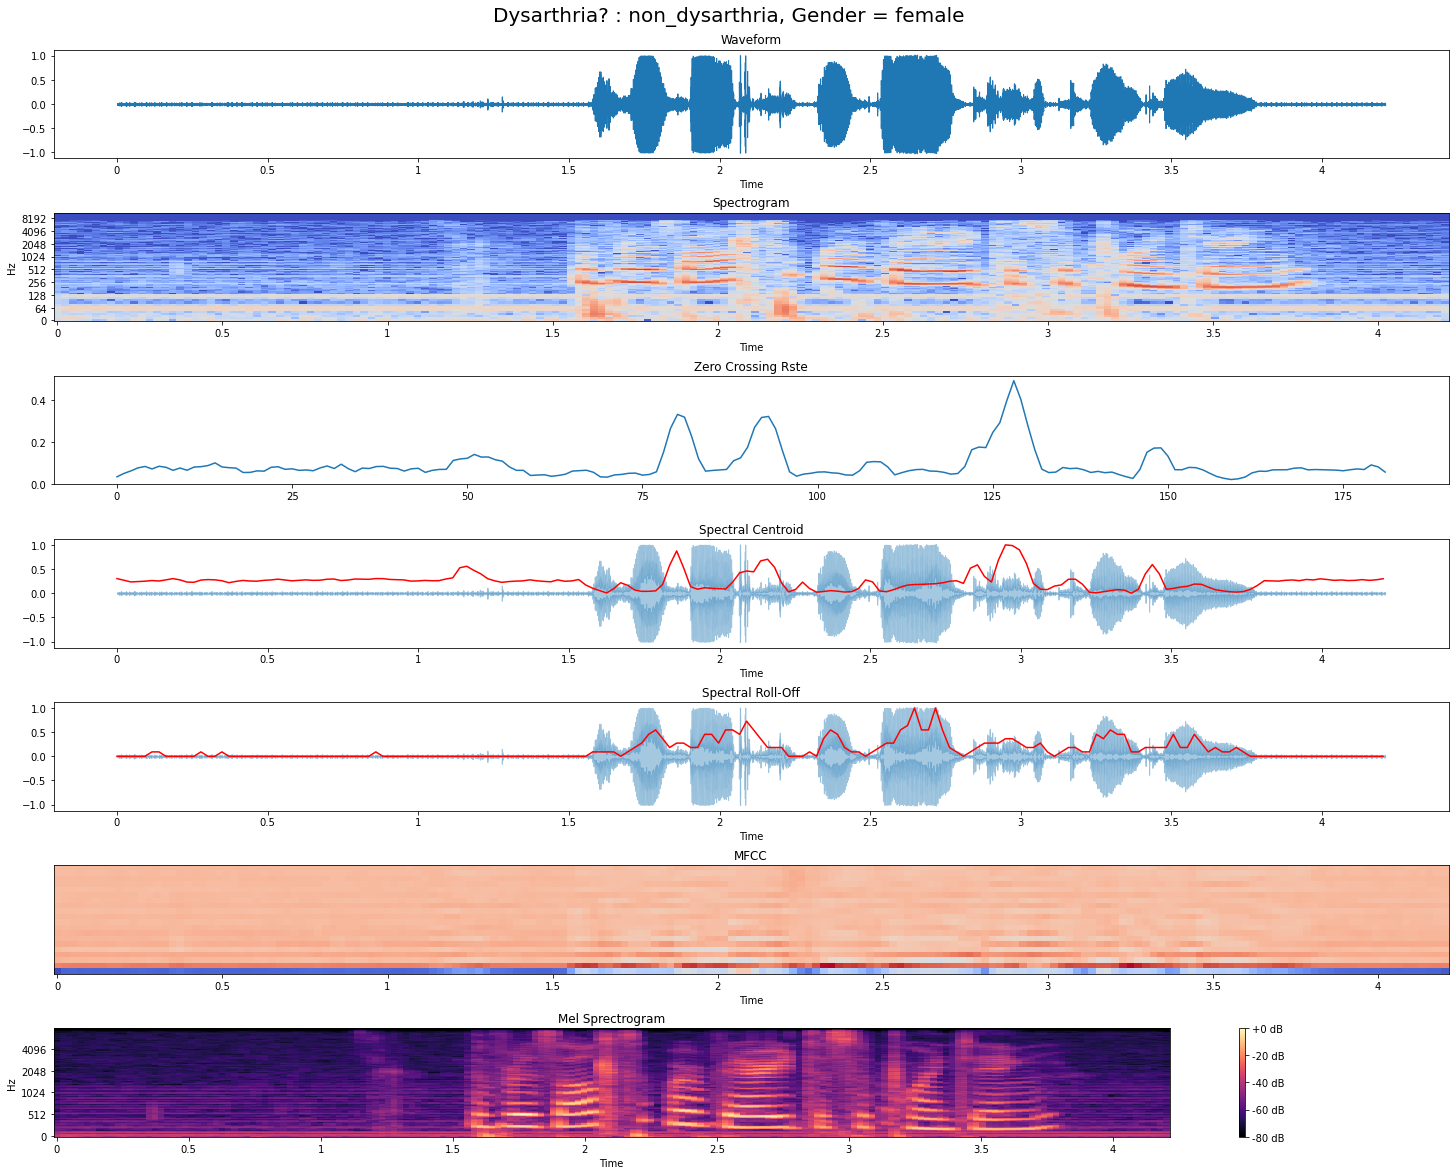

In [51]:
visualize(subset.loc[0]).plot()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Pass y=[ 1.4383855e-03  2.0578019e-03  2.0007466e-03 ... -2.9632036e-04
 -8.9055975e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Pass y=[ 1.4383855e-03  2.0578019e-03  2.0007466e-03 ... -2.9632036e-04
 -8.9055975e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error


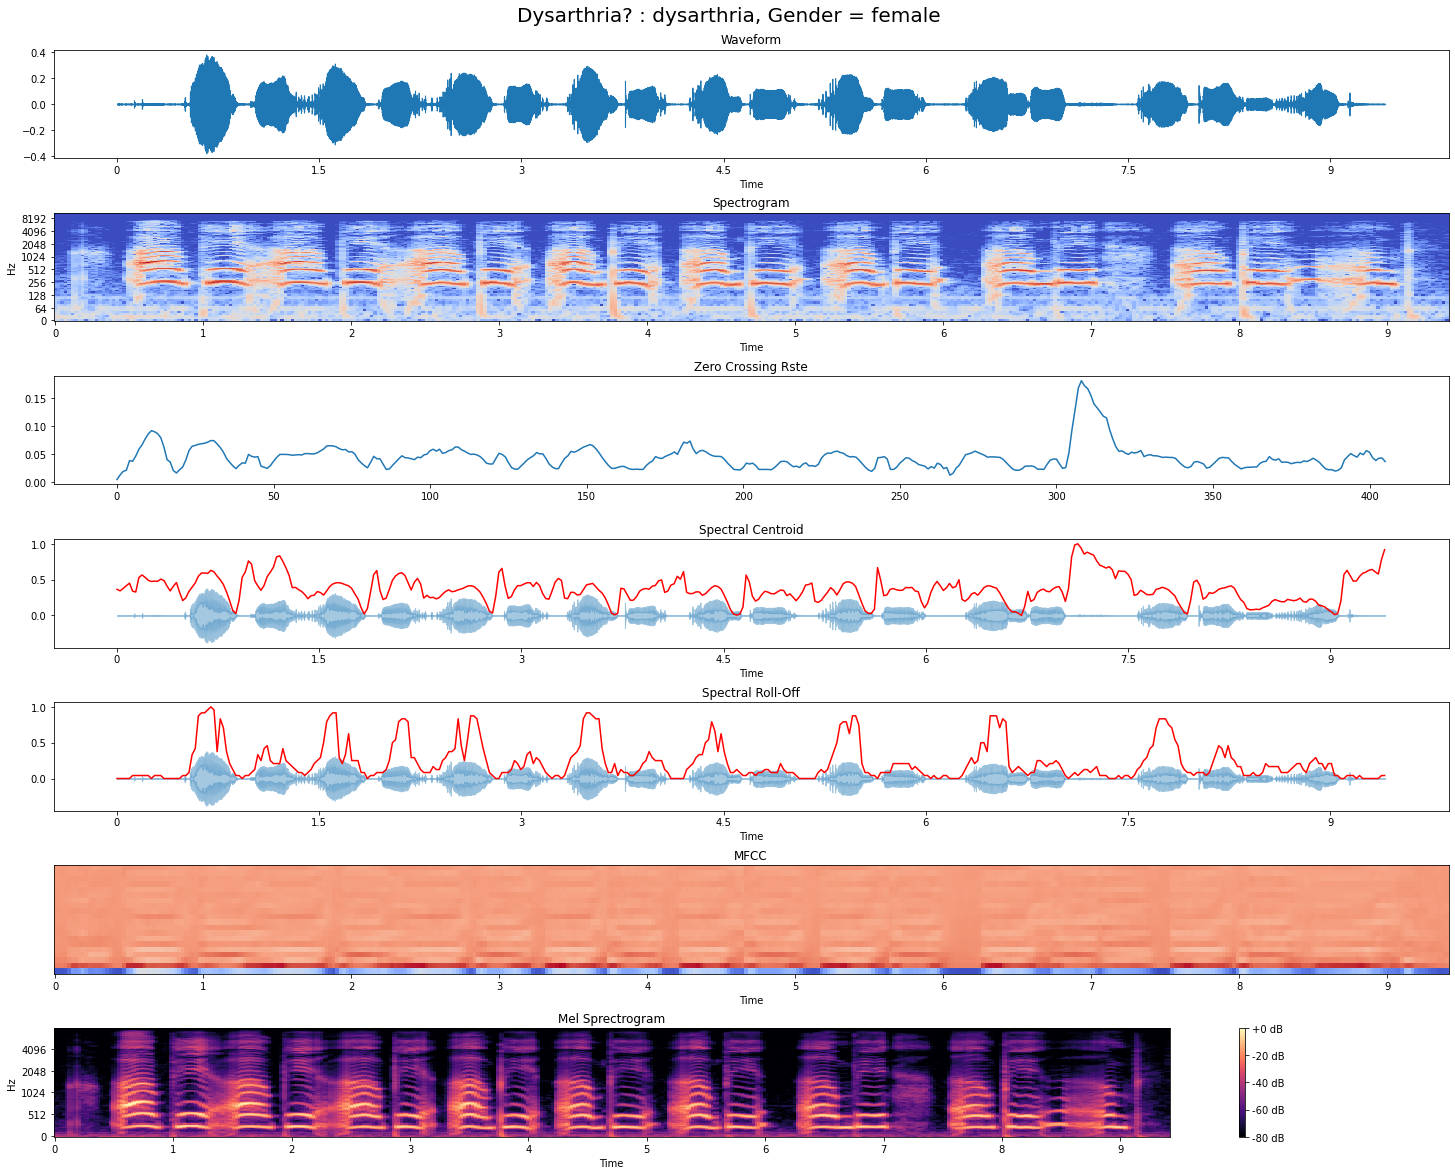

In [52]:
visualize(subset.loc[1]).plot()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Pass y=[-0.02173448 -0.01644661 -0.01039855 ... -0.02245431 -0.01172676
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Pass y=[-0.02173448 -0.01644661 -0.01039855 ... -0.02245431 -0.01172676
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error


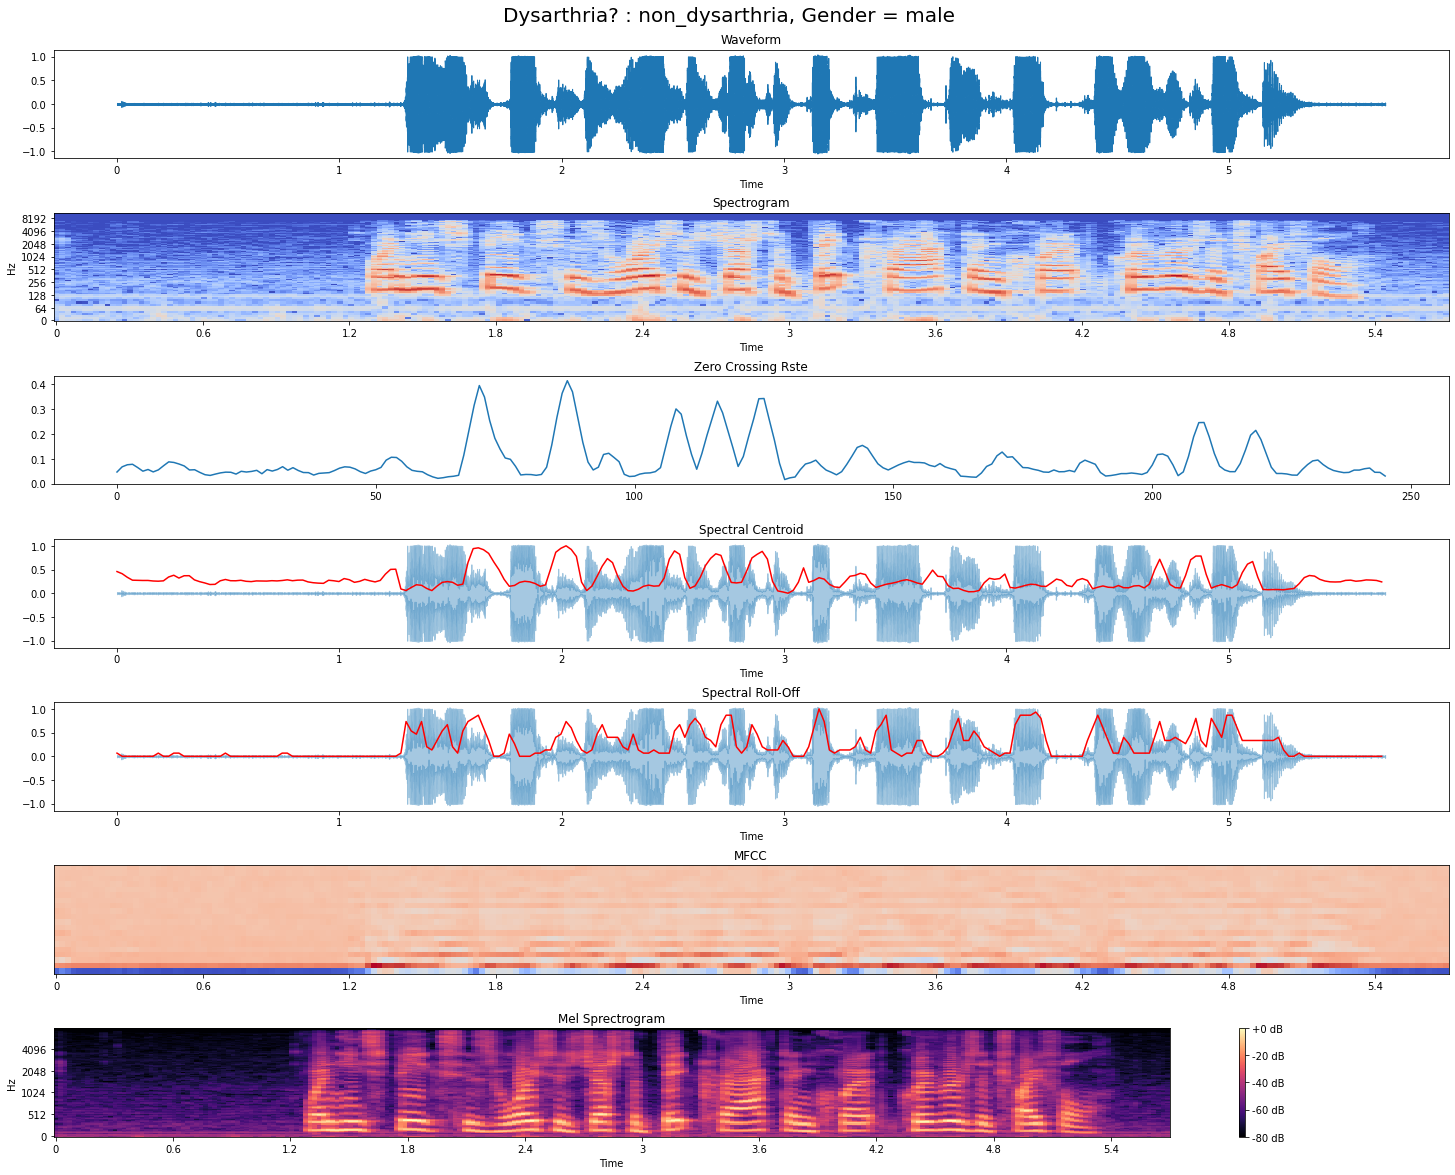

In [53]:
visualize(subset.loc[2]).plot()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Pass y=[0.00100133 0.00121381 0.00086274 ... 0.00047352 0.00050922 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Pass y=[0.00100133 0.00121381 0.00086274 ... 0.00047352 0.00050922 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error


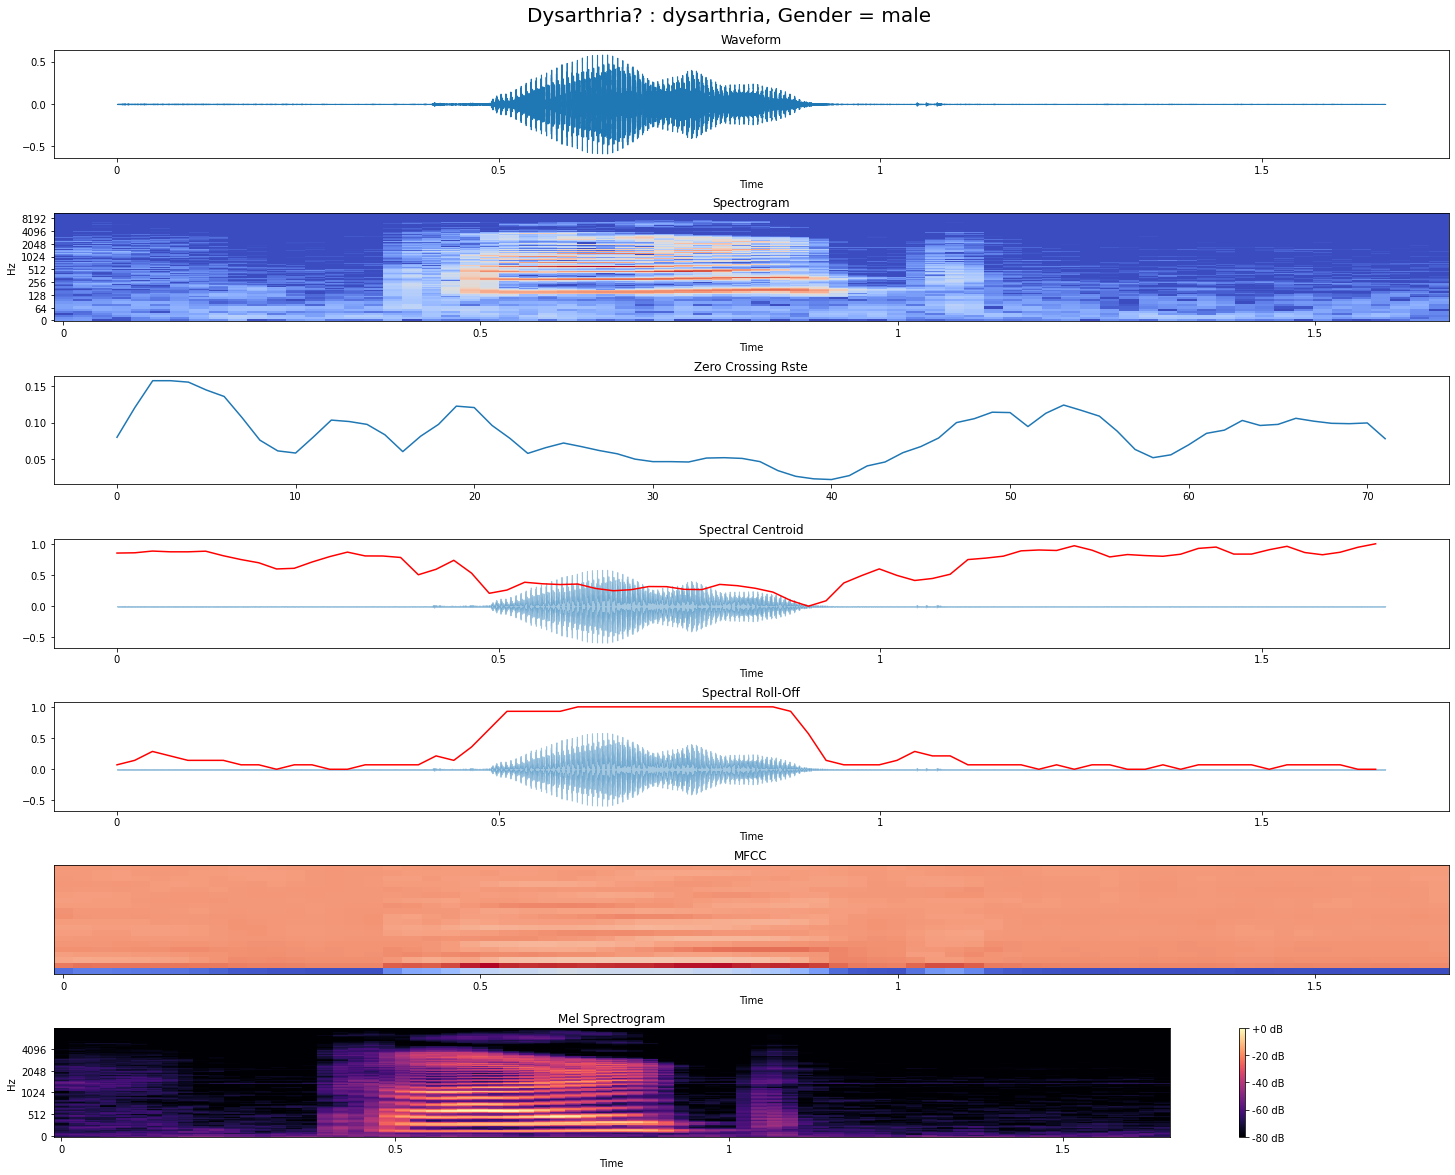

In [54]:
visualize(subset.loc[3]).plot()

> ### It can be seen that for signals where *is_dysarthria* is *dysarthria*, MFCC and Mel Spectrogram tends to shows repetitive patterns indicating that there are instances where the speaker is having difficulty speaking the word in one go and signifies that they are struggling to complete it which proves to be a good separation between the target variable levels for our model.

## Extracting characteristics of audio signals

In [56]:
from tqdm import tqdm 

In [57]:
%%time
X_df = pd.DataFrame((visualize(data.loc[i]).mfcc()) for i in tqdm(range(len(data))))
np.shape(X_df)

 30%|███       | 600/2000 [03:58<08:32,  2.73it/s]/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
 30%|███       | 601/2000 [03:59<12:09,  1.92it/s]

Error in librosa.load
Error reading audio


 78%|███████▊  | 1554/2000 [10:18<03:19,  2.24it/s]/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=209
  return f(*args, **kwargs)
 78%|███████▊  | 1568/2000 [10:23<02:41,  2.68it/s]/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=583
  return f(*args, **kwargs)
 80%|███████▉  | 1599/2000 [10:36<02:39,  2.52it/s]/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=581
  return f(*args, **kwargs)
 84%|████████▎ | 1672/2000 [11:08<02:33,  2.14it/s]/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=185
  return f(*args, **kwargs)
 85%|████████▌ | 1703/2000 [11:20<01:59,  2.48it/s]/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning

CPU times: user 5min 10s, sys: 3min 55s, total: 9min 6s
Wall time: 13min 19s


(2000, 128)

In [58]:
X_df = X_df.dropna()

## Preprocessing data, creating and training model

In [59]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [60]:
encoder = LabelEncoder()
encoder.fit(data['is_dysarthria'])
y = encoder.transform(data['is_dysarthria'])
y = np.delete(y, 600)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_df), y, test_size=0.10, random_state=42)
X_train.shape, X_test.shape

((1799, 128), (200, 128))

In [62]:
X_train = X_train.reshape(X_train.shape[0], 16, 8, 1)
X_test = X_test.reshape(X_test.shape[0], 16, 8, 1)

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer

In [64]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(InputLayer(input_shape=(16, 8, 1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = "same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = "same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid'))
model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding = "same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(len(data['is_dysarthria'].unique()), activation='softmax'))

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 8, 64)         640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 4, 32)          18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 2, 8)           2312      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 1, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0

In [66]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [67]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3)

In [68]:
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/500
57/57 [==============================] - 1s 6ms/step - loss: 0.5638 - accuracy: 0.7087 - val_loss: 0.4718 - val_accuracy: 0.7500
Epoch 2/500
57/57 [==============================] - 0s 4ms/step - loss: 0.3458 - accuracy: 0.8521 - val_loss: 0.2513 - val_accuracy: 0.8950
Epoch 3/500
57/57 [==============================] - 0s 4ms/step - loss: 0.2115 - accuracy: 0.9161 - val_loss: 0.1434 - val_accuracy: 0.9450
Epoch 4/500
57/57 [==============================] - 0s 4ms/step - loss: 0.1457 - accuracy: 0.9505 - val_loss: 0.1095 - val_accuracy: 0.9600
Epoch 5/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0823 - accuracy: 0.9750 - val_loss: 0.0646 - val_accuracy: 0.9750
Epoch 6/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0804 - accuracy: 0.9705 - val_loss: 0.0416 - val_accuracy: 0.9850
Epoch 7/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0603 - accuracy: 0.9783 - val_loss: 0.0525 - val_accuracy: 0.9900
Epoch 8/500
5

In [69]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:
history = pd.DataFrame(history.history)

In [71]:
history.head(3)

,loss,accuracy,val_loss,val_accuracy
0,0.563813,0.708727,0.471771,0.750
1,0.345828,0.852140,0.251270,0.895
2,0.211481,0.916065,0.143432,0.945


<AxesSubplot:>

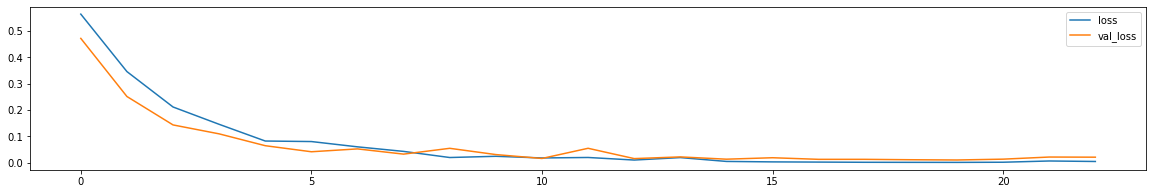

In [72]:
history[['loss', 'val_loss']].plot(figsize=(20,3))

<AxesSubplot:>

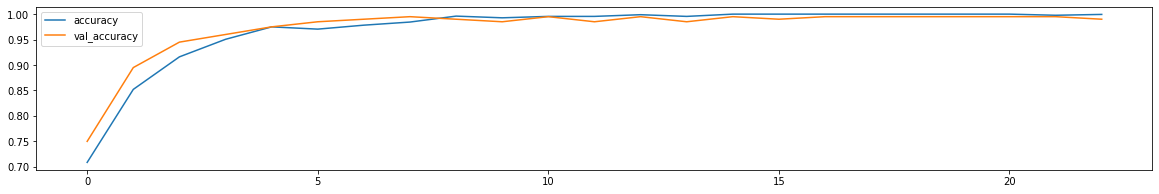

In [73]:
history[['accuracy', 'val_accuracy']].plot(figsize=(20,3))

## Evaluating model

In [74]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,confusion_matrix

In [75]:
prob_val = model.predict(X_test)
pred_val = np.argmax(prob_val, axis=1)
inverse = lambda x:encoder.inverse_transform(x)

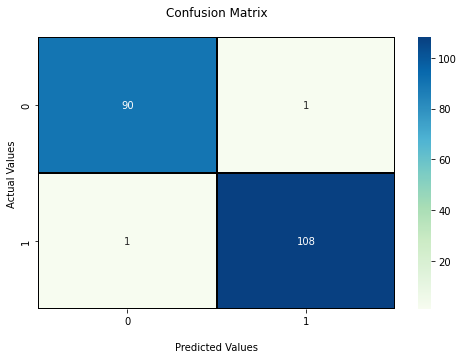

In [76]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(inverse(y_test), inverse(pred_val)), fmt='', linewidths=2,linecolor='black', annot=True, cmap='GnBu')

plt.title('Confusion Matrix\n');
plt.xlabel('\nPredicted Values');
plt.ylabel('Actual Values');

> ### Model is precisely classifying data with minimal missclassification.

In [77]:
print(classification_report(inverse(y_test), inverse(pred_val)))

                precision    recall  f1-score   support

    dysarthria       0.99      0.99      0.99        91
non_dysarthria       0.99      0.99      0.99       109

      accuracy                           0.99       200
     macro avg       0.99      0.99      0.99       200
  weighted avg       0.99      0.99      0.99       200



> ### Model has high recall value indicating that it is able to detect majority of the positive samples present in the data.

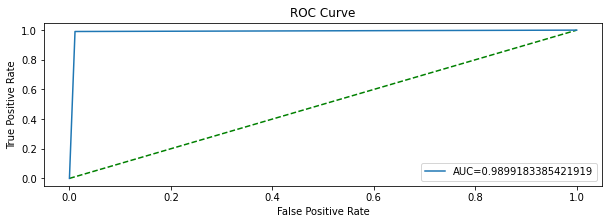

In [78]:
fpr, tpr, _ = roc_curve(y_test,  pred_val)
auc = roc_auc_score(y_test, pred_val)

plt.figure(figsize=(10,3))
plt.plot([min(fpr), max(fpr)], [min(tpr), max(tpr)], color='green', linestyle='dashed')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

> ### Model quickly learned the data and shows nearly ideal chracteristics which is a little sketchy. Limit data can be one reason for such behaviour. However in this case, model has correctly classified nearly all the positive class samples.